In [1]:
import sys
sys.executable

'/opt/anaconda/envs/juplab_hk_torch/bin/python'

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score


/opt/anaconda/envs/juplab_hk_torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sfds = Path('~/workspace/kinolab/notebooks/Datasets/KINO.DYSPNEA/0.12.7/KINO-DYSPNEA_2023-08-07_1624_rsp_sfds.h5').expanduser()
sfds.exists()


True

In [4]:
df = pd.read_hdf(sfds, key='df')

In [5]:
df.shape

(385, 55)

In [6]:
df.HF.value_counts()

False    221
True     164
Name: HF, dtype: int64

In [7]:
df.columns

Index(['age', 'tvexp_grad_p1p0_scg_nrg_rot_max_std',
       'tvins_rp1_scg_nrg_lin_tmax_mean',
       'lvexp_grad_p1p0_scg_pwr_lin_max_std',
       'lvins_grad_p0m1_scg_pwr_rot_max_std', 'tvexp_rm1_scg_pwr_rot_tmin_std',
       'lvexp_rp1_scg_nrg_lin_tmax_std', 'tvins_rm1_scg_pwr_lin_tmin_mean',
       'lvexp_rm1_scg_nrg_rot_tmax_mean', 'hvexp_rp1_scg_nrg_rot_tmax_std',
       'bsa', 'tvins_grad_p1p0_scg_nrg_rot_den_mean',
       'hvins_grad_p1m1_scg_pwr_lin_min_std', 'rsp_respiratory_rate_ppi_mean',
       'lvins_grad_p1p0_scg_pwr_rot_max_std',
       'tvins_grad_p0m1_scg_nrg_rot_max_std',
       'hvexp_grad_p1p0_scg_pwr_rot_max_mean',
       'lvexp_grad_p1m1_scg_pwr_rot_min_std', 'bmi', 'height',
       'hvins_grad_p1p0_scg_nrg_rot_itg_mean', 'hvins_rp0_scg_pwr_rot_min_std',
       'hvexp_rm1_scg_pwr_rot_tmax_std', 'lvexp_rp0_scg_nrg_lin_tmax_std',
       'hvexp_rp1_scg_pwr_lin_min_std', 'lvins_rm1_scg_nrg_lin_tmax_std',
       'weight', 'tvins_rp0_scg_nrg_lin_tmax_mean',
       'gra

In [8]:
'patient_id' in df.columns

True

In [9]:
df.patient_id.nunique()

381

In [10]:
len(df.patient_id)

385

In [11]:
df.groupby(['patient_id']).apply(len) != 1

patient_id
KINO-DYSPNEA_AB     True
KINO-DYSPNEA_AF    False
KINO-DYSPNEA_AG    False
KINO-DYSPNEA_AH    False
KINO-DYSPNEA_AI    False
                   ...  
KINO-DYSPNEA_ZS    False
KINO-DYSPNEA_ZU    False
KINO-DYSPNEA_ZV    False
KINO-DYSPNEA_ZY    False
KINO-DYSPNEA_ZZ    False
Length: 381, dtype: bool

In [12]:
# Fttb, make sure no records are reused from the same patient
df = df.drop_duplicates(subset=["patient_id"], keep='first')

In [13]:
df.shape

(381, 55)

In [15]:
X_df = df.drop(columns=["HF", "patient_id"])
y_df = df["HF"]

In [17]:
tabnet_params = {"cat_emb_dim":2,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
clf.device

In [19]:
max_epochs = 1000

In [20]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [ ]:
# TypeError: Pandas DataFrame are not supported: apply X.values when calling fit

In [21]:
clf.fit(
        X_train=X_df.values, y_train=y_df.values,
        eval_set=[(X_df.values, y_df.values)],
        eval_name=['train'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=100,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug, #aug, None
        compute_importance=False
    )

epoch 0  | loss: 0.91311 | train_auc: 0.51285 |  0:00:00s
epoch 1  | loss: 0.84108 | train_auc: 0.58118 |  0:00:00s
epoch 2  | loss: 0.78516 | train_auc: 0.53819 |  0:00:00s
epoch 3  | loss: 0.73598 | train_auc: 0.60438 |  0:00:00s
epoch 4  | loss: 0.66907 | train_auc: 0.54539 |  0:00:00s
epoch 5  | loss: 0.72649 | train_auc: 0.50815 |  0:00:00s
epoch 6  | loss: 0.66414 | train_auc: 0.46676 |  0:00:00s
epoch 7  | loss: 0.65336 | train_auc: 0.47557 |  0:00:00s
epoch 8  | loss: 0.63281 | train_auc: 0.42614 |  0:00:00s
epoch 9  | loss: 0.64637 | train_auc: 0.43197 |  0:00:00s
epoch 10 | loss: 0.63543 | train_auc: 0.43533 |  0:00:00s
epoch 11 | loss: 0.65438 | train_auc: 0.46748 |  0:00:00s
epoch 12 | loss: 0.60984 | train_auc: 0.48247 |  0:00:00s
epoch 13 | loss: 0.6216  | train_auc: 0.50189 |  0:00:00s
epoch 14 | loss: 0.59749 | train_auc: 0.51545 |  0:00:00s
epoch 15 | loss: 0.58958 | train_auc: 0.53345 |  0:00:00s
epoch 16 | loss: 0.59658 | train_auc: 0.52702 |  0:00:00s
epoch 17 | los

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# Train-Validation-Test spli

In [22]:
if 'set' not in df.columns:
    df['set'] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(df.shape[0],))

train_indices = df[df.set=="train"].index
valid_indices = df[df.set=="valid"].index
test_indices = df[df.set=="test"].index

In [23]:
X_df = df.drop(columns=["HF", "patient_id", "set"])
y_df = df["HF"]

In [40]:
X_train = X_df.loc[train_indices]
y_train = y_df.loc[train_indices]

X_valid = X_df.loc[valid_indices]
y_valid = y_df.loc[valid_indices]

X_test = X_df.loc[test_indices]
y_test = y_df.loc[test_indices]

In [74]:
tabnet_params = {"cat_emb_dim":2,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=3e-2),
                 "scheduler_params":{"step_size":25, # how to use learning rate scheduler
                                 "gamma":0.95},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
                }

clf2 = TabNetClassifier(**tabnet_params)

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [76]:
max_epochs = 2000

In [103]:
clf2.fit(
        X_train=X_train.values, y_train=y_train.values,
        eval_set=[(X_train.values, y_train.values), (X_valid.values, y_valid.values)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=200,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug, #aug, None
        compute_importance=False
    )

epoch 0  | loss: 0.94205 | train_auc: 0.48664 | valid_auc: 0.56818 |  0:00:00s
epoch 1  | loss: 0.82773 | train_auc: 0.49729 | valid_auc: 0.43636 |  0:00:00s
epoch 2  | loss: 0.77196 | train_auc: 0.53776 | valid_auc: 0.48182 |  0:00:00s
epoch 3  | loss: 0.65254 | train_auc: 0.53916 | valid_auc: 0.31364 |  0:00:00s
epoch 4  | loss: 0.68035 | train_auc: 0.517   | valid_auc: 0.32273 |  0:00:00s
epoch 5  | loss: 0.65397 | train_auc: 0.54049 | valid_auc: 0.51364 |  0:00:00s
epoch 6  | loss: 0.67125 | train_auc: 0.54834 | valid_auc: 0.40909 |  0:00:00s
epoch 7  | loss: 0.63945 | train_auc: 0.54291 | valid_auc: 0.41818 |  0:00:00s
epoch 8  | loss: 0.6003  | train_auc: 0.52599 | valid_auc: 0.46818 |  0:00:00s
epoch 9  | loss: 0.58947 | train_auc: 0.54126 | valid_auc: 0.48182 |  0:00:00s
epoch 10 | loss: 0.64847 | train_auc: 0.53239 | valid_auc: 0.38182 |  0:00:00s
epoch 11 | loss: 0.65072 | train_auc: 0.50615 | valid_auc: 0.38636 |  0:00:00s
epoch 12 | loss: 0.60419 | train_auc: 0.52158 | vali

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [104]:
import matplotlib.pyplot as plt

In [105]:
# What's in the history
clf2.history.__dict__['history'].keys()

dict_keys(['loss', 'lr', 'train_auc', 'valid_auc'])

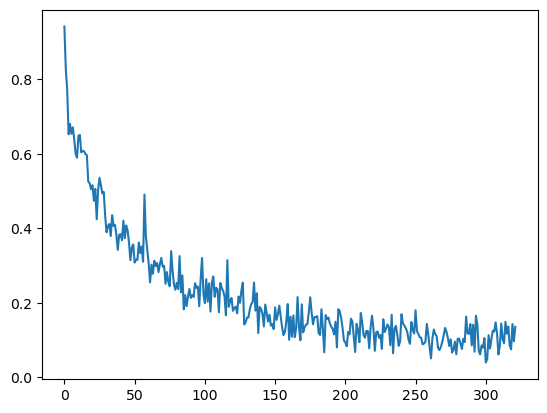

In [106]:
plt.plot(clf2.history['loss'])

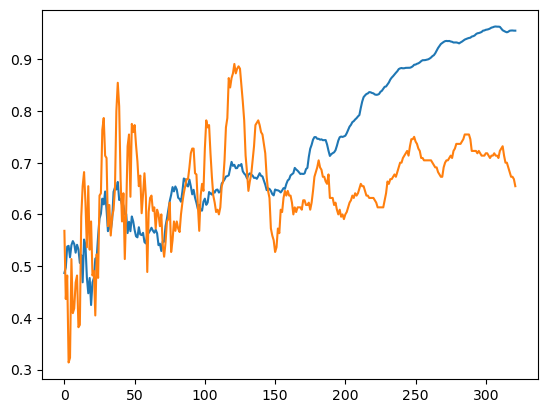

In [107]:
# plot auc
plt.plot(clf2.history['train_auc'])
plt.plot(clf2.history['valid_auc'])

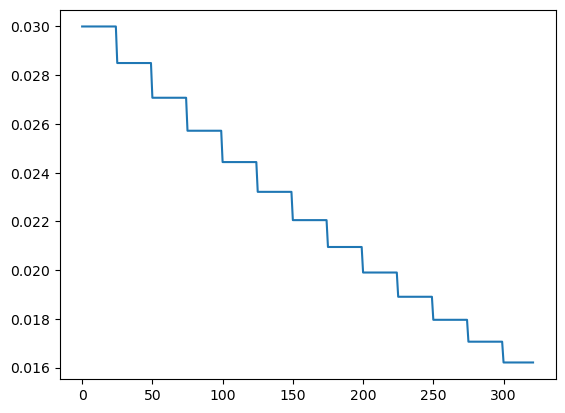

In [108]:
# plot learning rates
plt.plot(clf2.history['lr'])